# AIPI 590 - XAI | Assignment #3
Interpretable Machine Learning for Customer Churn Prediction

## Rishabh Shah

## Overview
In this notebook, we analyze a dataset from a telecommunications company that is interested in understanding customer churn. We will build multiple interpretable models (Linear Regression, Logistic Regression, and GAM) to predict customer churn and compare their performance.

---

## 1. Importing Libraries and Loading Data
We start by importing necessary libraries and loading the dataset.

In [1]:
# !pip install pandas numpy matplotlib seaborn scikit-learn pygam imblearn shap lime

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error, roc_auc_score
from statsmodels.gam.api import GLMGam, BSplines

# Load dataset
# data = pd.read_csv('telco_customer_churn.csv')
data = pd.read_csv('Telco-Customer-Churn.csv')


# Display first few rows of the data
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  

[5 rows x 21 columns]

## 2. Exploratory Data Analysis (EDA)

### 2.1 Data Cleaning and Preprocessing
We need to check for missing values, data types, and clean any anomalies in the data.

In [3]:
# Checking for missing values and data types
data.info()

# Summary statistics
data.describe()

# Replace missing values or remove columns if necessary
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data.dropna(inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### 2.2 Understanding Target Variable (Churn)
We need to understand the distribution of the target variable (Churn) to check for imbalance in the dataset.

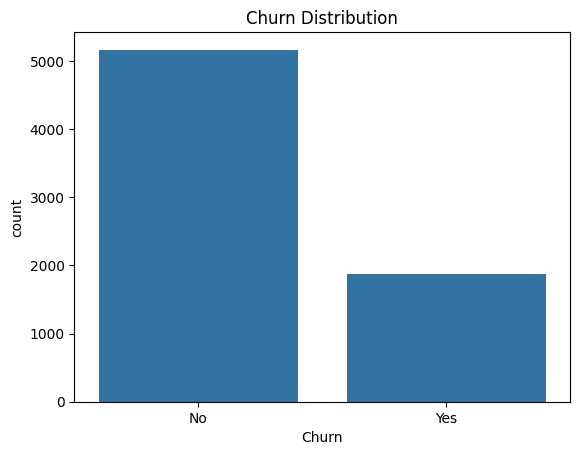

In [4]:
# Plotting churn distribution
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.show()

# Converting Churn column to binary values (Yes = 1, No = 0)
data['Churn'] = data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)


### 2.3 Feature Relationships
We will analyze relationships between customer features and churn. For numeric features, correlation analysis will help, while categorical features will use group comparisons.

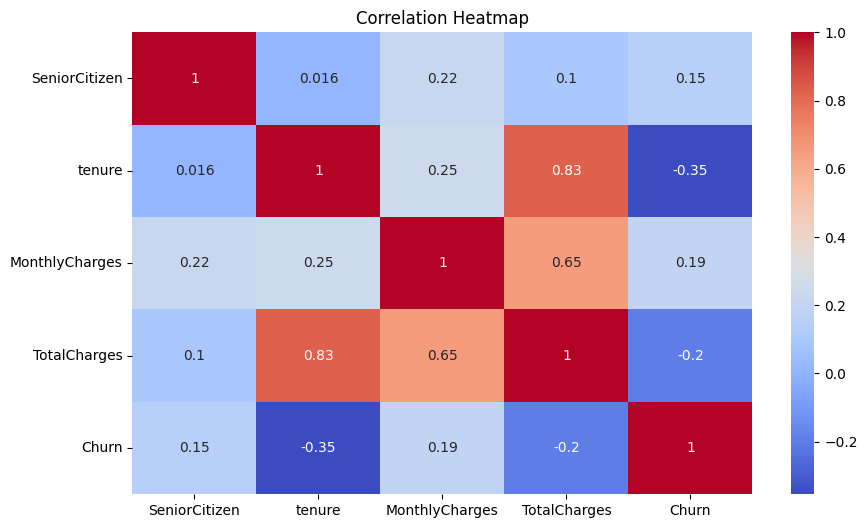

In [5]:
# Select only numeric columns
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Correlation Heatmap for numerical features
plt.figure(figsize=(10,6))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


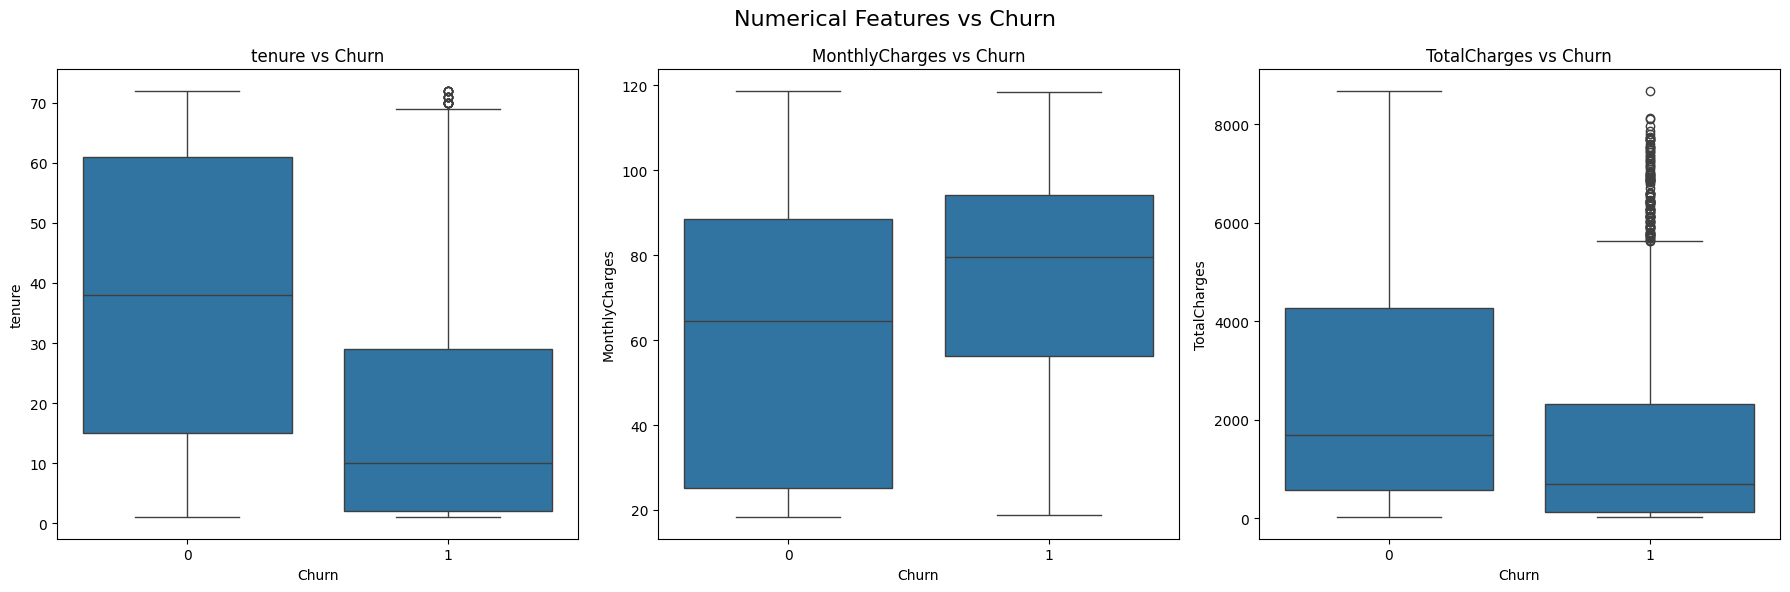

In [6]:
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Numerical Features vs Churn', fontsize=16)

for i, feature in enumerate(numerical_features):
    sns.boxplot(x='Churn', y=feature, data=data, ax=axes[i])
    axes[i].set_title(f'{feature} vs Churn')
    axes[i].set_xlabel('Churn')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

In [7]:
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'MultipleLines', 'InternetService',
                        'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                        'TechSupport', 'StreamingTV', 'StreamingMovies',
                        'Contract', 'PaperlessBilling', 'PaymentMethod']

# Calculate the number of rows needed (4 plots per row)
n_rows = (len(categorical_features) + 3) // 4

fig, axes = plt.subplots(n_rows, 4, figsize=(20, 5*n_rows))
fig.suptitle('Categorical Features vs Churn', fontsize=16)

for i, feature in enumerate(categorical_features):
    row = i // 4
    col = i % 4
    ax = axes[row, col]
    
    sns.countplot(x=feature, hue='Churn', data=data, ax=ax)
    ax.set_title(f'{feature} vs Churn')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)
    
    # Remove y-axis label to save space
    ax.set_ylabel('')
    
    # Only show legend for the rightmost plots
    if col != 3:
        ax.get_legend().remove()

# Remove any unused subplots
for i in range(len(categorical_features), n_rows * 4):
    row = i // 4
    col = i % 4
    fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

### 2.4 Feature Engineering

In [8]:
# Drop original 'Churn' column as we have 'Churn_numeric'
data_model = data.drop(['Churn'], axis=1)

# One-hot encoding for categorical variables
data_model = pd.get_dummies(data_model, drop_first=True)

# Display the first few rows of the processed data
data_model.head()

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  customerID_0003-MKNFE  \
0              0       1           29.85         29.85                  False   
1              0      34           56.95       1889.50                  False   
2              0       2           53.85        108.15                  False   
3              0      45           42.30       1840.75                  False   
4              0       2           70.70        151.65                  False   

   customerID_0004-TLHLJ  customerID_0011-IGKFF  customerID_0013-EXCHZ  \
0                  False                  False                  False   
1                  False                  False                  False   
2                  False                  False                  False   
3                  False                  False                  False   
4                  False                  False                  False   

   customerID_0013-MHZWF  customerID_0013-SMEOE  ...  \
0                  False                  False  ...   
1                  False                  False  ...   
2                  False                  False  ...   
3                  False                  False  ...   
4                  False                  False  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            False   
1                            False            False   
2                            False            False   
3                            False            False   
4                            False            False   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                False                False   
1                                False                False   
2                                False                False   
3                                False                False   
4                                False                False   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0              False              False                  True   
1               True              False                 False   
2              False              False                  True   
3               True              False                 False   
4              False              False                  True   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  
0                       False  
1                        True  
2                        True  
3                       False  
4                       False  

[5 rows x 7061 columns]

### 2.5 Feature Scaling

In [9]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Select numerical features for scaling
num_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Apply scaler
data_model[num_features] = scaler.fit_transform(data_model[num_features])

# Display scaled features
data_model.head()

SeniorCitizen    tenure  MonthlyCharges  TotalCharges  \
0              0 -1.280248       -1.161694     -0.994194   
1              0  0.064303       -0.260878     -0.173740   
2              0 -1.239504       -0.363923     -0.959649   
3              0  0.512486       -0.747850     -0.195248   
4              0 -1.239504        0.196178     -0.940457   

   customerID_0003-MKNFE  customerID_0004-TLHLJ  customerID_0011-IGKFF  \
0                  False                  False                  False   
1                  False                  False                  False   
2                  False                  False                  False   
3                  False                  False                  False   
4                  False                  False                  False   

   customerID_0013-EXCHZ  customerID_0013-MHZWF  customerID_0013-SMEOE  ...  \
0                  False                  False                  False  ...   
1                  False                  False                  False  ...   
2                  False                  False                  False  ...   
3                  False                  False                  False  ...   
4                  False                  False                  False  ...   

   StreamingTV_No internet service  StreamingTV_Yes  \
0                            False            False   
1                            False            False   
2                            False            False   
3                            False            False   
4                            False            False   

   StreamingMovies_No internet service  StreamingMovies_Yes  \
0                                False                False   
1                                False                False   
2                                False                False   
3                                False                False   
4                                False                False   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0              False              False                  True   
1               True              False                 False   
2              False              False                  True   
3               True              False                 False   
4              False              False                  True   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                  False                            True   
1                                  False                           False   
2                                  False                           False   
3                                  False                           False   
4                                  False                            True   

   PaymentMethod_Mailed check  
0                       False  
1                        True  
2                        True  
3                       False  
4                       False  

[5 rows x 7061 columns]

## 3. Assumptions for Models
Before building models, we check if the assumptions for each model type (Linear, Logistic, and GAM) hold true.

### 3.1 Assumptions for Linear Regression

Linear regression assumes a linear relationship between the independent variables and the target. We check for linearity and multicollinearity.

In [10]:
# Pairplot to check for linearity
sns.pairplot(data[['tenure', 'MonthlyCharges', 'TotalCharges']], diag_kind='kde')
plt.show()

# VIF for multicollinearity check
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data[['tenure', 'MonthlyCharges', 'TotalCharges']]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

feature       VIF
0          tenure  6.332432
1  MonthlyCharges  3.361075
2    TotalCharges  8.079181

The data exhibits multicollinearity, especially between 'tenure' and 'TotalCharges', as indicated by VIF values exceeding the common threshold of 5. This suggests a strong linear relationship between customer tenure and their total charges, which is intuitively understandable (longer tenure likely leads to higher cumulative charges). Consequently, in a linear regression model, it might be challenging to accurately disentangle the independent influence of each of these features on churn, as their effects could be confounded. This could lead to inflated standard errors for the coefficients and difficulties in interpreting the unique contribution of each predictor.

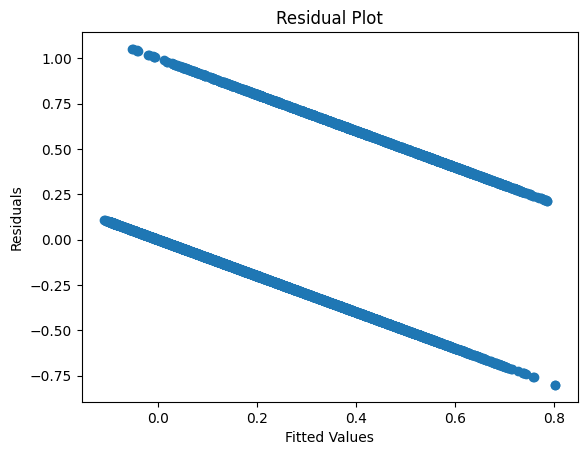

In [11]:
import statsmodels.api as sm


X_with_constant = sm.add_constant(X) 
model = sm.OLS(data['Churn'], X_with_constant).fit()
plt.figure()
plt.scatter(model.fittedvalues, model.resid)
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

The residual plot reveals a distinct non-random pattern, with residuals clustered along two lines. This indicates that the linear regression model is not adequately capturing the relationship between the predictors and the target variable, violating the assumption of linearity and potentially suggesting the presence of a categorical or non-linear effect not accounted for in the model. Further investigation and potential model adjustments are necessary to address this issue and improve the model's fit.

In [12]:
plt.figure()
plt.hist(model.resid)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")
plt.show()

The histogram of residuals indicates a bimodal distribution, with two distinct peaks around -0.25 and 0. This suggests that the errors might not be normally distributed, potentially violating one of the assumptions of linear regression. It's important to further investigate this using a Q-Q plot and consider whether transformations or alternative models might be necessary if the deviation from normality is significant.

In [13]:
# Check for normality of residuals
plt.figure()
sm.qqplot(model.resid, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

<Figure size 640x480 with 0 Axes>

The Q-Q plot shows deviations from the straight diagonal line, particularly in the tails and around the middle, indicating that the residuals are not perfectly normally distributed. This suggests a potential violation of the normality assumption in linear regression. The deviations, especially the "jumps" in the middle, might indicate the presence of distinct groups or non-linear patterns in the data that the model is not capturing. Further investigation and potential transformations or alternative models might be necessary if the deviation from normality is deemed significant.

Reason: LIME helps in explaining individual predictions by approximating the model locally with an interpretable model.

### 3.2 Assumptions for Logistic Regression
Logistic regression assumes that the log-odds of the dependent variable is a linear combination of the independent variables. We check this assumption with visualizations.

In [14]:
# Linearity of the Logit (Log-Odds)

X_with_constant = sm.add_constant(X)
logit_model = sm.Logit(data['Churn'], X_with_constant).fit()

# Get predicted probabilities
predicted_probs = logit_model.predict(X_with_constant)

# Calculate log-odds 
log_odds = np.log(predicted_probs / (1 - predicted_probs))

# Plot log-odds against each predictor in one chart
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, feature in enumerate(X.columns):
    axes[i].scatter(X[feature], log_odds)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Log-Odds")
    axes[i].set_title(f"Log-Odds vs. {feature}")

plt.tight_layout()
plt.show()

Optimization terminated successfully.
         Current function value: 0.453372
         Iterations 7


The log-odds vs. predictor plots broadly support the linearity assumption of logistic regression for 'tenure', 'MonthlyCharges', and 'TotalCharges', showing expected relationships with churn. However, 'TotalCharges' displays a less uniform data spread, hinting at potential multicollinearity with 'tenure', which needs further examination.

In [15]:
# # Logistic curves for numeric variables in one chart
# fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# # Logistic curve for MonthlyCharges
# sns.regplot(x='MonthlyCharges', y='Churn', data=data, logistic=True, ax=axes[0])
# axes[0].set_title('Logistic Curve for MonthlyCharges')

# # Logistic curve for tenure
# sns.regplot(x='tenure', y='Churn', data=data, logistic=True, ax=axes[1])
# axes[1].set_title('Logistic Curve for Tenure')

# # Logistic curve for TotalCharges
# sns.regplot(x='TotalCharges', y='Churn', data=data, logistic=True, ax=axes[2])
# axes[2].set_title('Logistic Curve for TotalCharges')

# plt.tight_layout()
# plt.show()

The logistic curves for 'MonthlyCharges', 'tenure', and 'TotalCharges' seem to contradict the expected S-shaped relationship typically assumed in logistic regression. Instead of gradually transitioning from low to high probability, the curves mainly show flat lines at either 0 or 1, suggesting an extremely strong and immediate influence of these predictors on churn.

### 3.3 Assumptions for GAM
GAM can handle non-linear relationships. We will explore non-linearity by plotting the relationship between numeric features and churn.

In [16]:
import numpy as np

# Non-linear relationship check for GAM in one plot
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add jitter to the x-values
jitter = 0.1

# Non-linear relationship for tenure
sns.scatterplot(x=data['tenure'] + np.random.uniform(-jitter, jitter, size=len(data)), y='Churn', data=data, ax=axes[0])
axes[0].set_title('Non-linear Relationship between Tenure and Churn')

# Non-linear relationship for MonthlyCharges
sns.scatterplot(x=data['MonthlyCharges'] + np.random.uniform(-jitter, jitter, size=len(data)), y='Churn', data=data, ax=axes[1])
axes[1].set_title('Non-linear Relationship between MonthlyCharges and Churn')

# Non-linear relationship for TotalCharges
sns.scatterplot(x=data['TotalCharges'] + np.random.uniform(-jitter, jitter, size=len(data)), y='Churn', data=data, ax=axes[2])
axes[2].set_title('Non-linear Relationship between TotalCharges and Churn')

plt.tight_layout()
plt.show()

## 4. Linear Regression

### 4.1 Model Building
We treat churn as a continuous variable and build a linear regression model.

In [17]:
# Define features and target
X = data[['tenure', 'MonthlyCharges', 'TotalCharges']]
y = data['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Coefficients interpretation
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
coefficients


Feature  Coefficient
0          tenure    -0.002658
1  MonthlyCharges     0.007261
2    TotalCharges    -0.000078

### 4.2 Residual Analysis for Linear Regression

Reason: Residual analysis checks whether the errors are randomly distributed. A non-random pattern indicates that the model does not capture all trends in the data.

In [18]:
# Predicting on the test set
y_pred = linear_model.predict(X_test)

# Residuals
residuals = y_test - y_pred

# Plotting residuals
plt.figure(figsize=(10,6))
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Linear Regression')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


The residual plot shows a clear non-random pattern, with residuals tightly clustered along two distinct lines. This indicates the linear regression model is not adequately capturing the relationship in the data, violating the assumption of linearity. The model is likely misspecified, potentially missing a key categorical predictor or a non-linear relationship. This pattern suggests a fundamental problem with the model's structure and requires further investigation and adjustments to improve its fit.

### 4.3 Model Evaluation
We evaluate the model using mean squared error (MSE) and R-squared.

In [20]:
# Predictions and evaluation
y_pred = linear_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = linear_model.score(X_test, y_test)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.15475092221279654
R-squared: 0.20716305869971707


### 4.4 Display coefficients

The coefficients represent the change in the predicted churn value for a one-unit change in the corresponding feature, holding other features constant. For instance, a positive coefficient for 'MonthlyCharges' suggests that higher monthly charges are associated with an increased likelihood of churn.

          Feature  Coefficient
0          tenure    -0.002658
1  MonthlyCharges     0.007261
2    TotalCharges    -0.000078


<Figure size 1000x600 with 0 Axes>

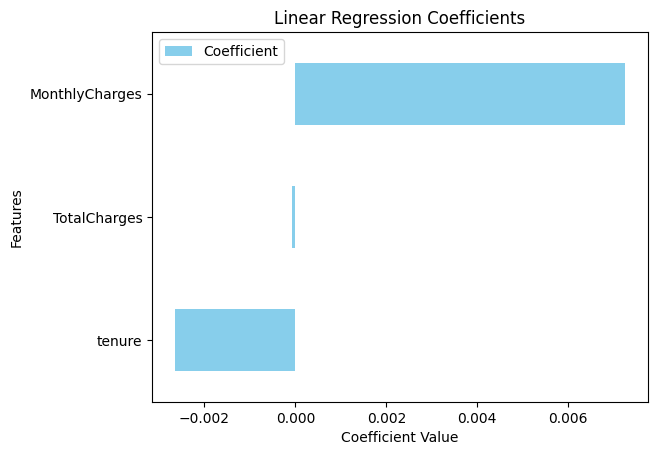

In [21]:
# Display coefficients
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': linear_model.coef_})
print(coefficients)

# Visualize coefficients
plt.figure(figsize=(10, 6))
coefficients.sort_values(by='Coefficient').plot(x='Feature', y='Coefficient', kind='barh', color='skyblue')
plt.title('Linear Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()

The linear regression coefficients indicate that 'MonthlyCharges' has the strongest positive association with churn, followed by a very weak positive association with 'TotalCharges'. Conversely, 'tenure' has a negative association with churn. This means higher monthly charges increase churn likelihood, while longer customer tenure decreases it. However, the extremely small magnitude of the coefficients suggests the model's predictive power is weak, likely due to data issues or model misspecification identified earlier.

### 4.5 Analyzing Feature Importance using Coefficients

In [22]:
# Example: Analyzing Feature Importance using Coefficients

# Get absolute values of coefficients for feature importance ranking
coefficients['Absolute Coefficient'] = abs(coefficients['Coefficient'])

# Sort coefficients by absolute value in descending order
coefficients = coefficients.sort_values(by='Absolute Coefficient', ascending=False)

# Display feature importance ranking
print("Feature Importance Ranking:")
print(coefficients[['Feature', 'Absolute Coefficient']])

Feature Importance Ranking:
          Feature  Absolute Coefficient
1  MonthlyCharges              0.007261
0          tenure              0.002658
2    TotalCharges              0.000078


### 4.6 SHAP and LIME for Feature Importance
SHAP values provide a way to understand the contribution of each feature to individual predictions made by the linear regression model. The summary plot above shows the following:

* **Feature Importance:** Features are ranked by their overall impact on the model's output. Features with wider bars and a wider range of SHAP values have a greater influence.
* **Feature Effects:** The color of the points indicates the feature value (red for high, blue for low). The horizontal position shows the impact on the prediction (positive or negative).
* **Interactions:** You can observe potential interactions by looking for color patterns. For example, if a feature's effect is consistently positive for high values of another feature and negative for low values, it suggests an interaction.

In [26]:
import shap

# Create SHAP explainer for Linear Regression
explainer = shap.LinearExplainer(linear_model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X.columns) 


The SHAP summary plot reveals the impact of 'MonthlyCharges', 'TotalCharges', and 'tenure' on the model's prediction. Higher 'MonthlyCharges' generally contribute to a higher prediction (likely towards churn), while higher 'TotalCharges' tend to slightly lower the prediction (likely towards no churn). 'Tenure' has a more nuanced impact, with lower tenure values pushing the prediction higher and medium to high tenure values pushing it lower. This suggests that while higher monthly charges increase churn risk, longer tenure and accumulated charges can mitigate that risk. The plot also confirms 'MonthlyCharges' as the most influential predictor, aligning with previous observations.


LIME provides local explanations for individual predictions. It works by creating a simpler, interpretable model (e.g., a linear model) that approximates the behavior of the complex model (linear regression in this case) in the vicinity of the instance being explained.

The LIME plot above shows the following for the selected prediction:

* **Prediction:** The model's prediction for the instance (e.g., probability of churn).
* **Feature Contributions:** The bar chart shows how each feature contributes to the prediction. Features with positive values push the prediction towards "Churn", while features with negative values push it towards "Not Churn".
* **Local Interpretability:** The LIME explanation is specific to the instance being explained and may not generalize to other instances.

In [24]:
import lime
import lime.lime_tabular

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X.columns, 
    class_names=['Not Churn', 'Churn'], # Assuming 'Churn' is 0 or 1
    mode='regression' 
)

# Explain a single prediction (e.g., the first prediction in the test set)
i = 0  
exp = explainer.explain_instance(X_test.values[i], linear_model.predict, num_features=3) 

# Show the explanation in the notebook
exp.show_in_notebook(show_table=True) 

/opt/anaconda3/envs/tourguideenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


The LIME output explains how the model arrived at its prediction for a specific customer. The top section shows the prediction is slightly negative (-0.04), closer to the minimum possible predicted value. The middle section highlights factors pushing the prediction lower (negative): lower monthly charges and longer tenure. The bottom section shows the customer's actual values for these features: $25 monthly charges and a 61-month tenure, which align with the negative influences. This visualization helps understand the individual prediction by highlighting which features played the most significant role.

## 5. Logistic Regression

### 5.1 Model Building

We now treat churn as a binary variable and build a logistic regression model.

In [27]:
# Fit logistic regression model
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train, y_train)

# Coefficients interpretation
logistic_coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': logistic_model.coef_[0]})
logistic_coefficients


Feature  Coefficient
0          tenure    -0.069502
1  MonthlyCharges     0.030939
2    TotalCharges     0.000163

### 5.2 Model Evaluation

We use accuracy, ROC-AUC score to evaluate the logistic regression model.

In [28]:
# Predictions and evaluation
y_pred_log = logistic_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_log)
roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print(f'ROC-AUC: {roc_auc}')


Accuracy: 0.7748815165876777
ROC-AUC: 0.7995584524084884


### 5.3 Display coefficients
Visualizing the coefficients for Logistic Regression

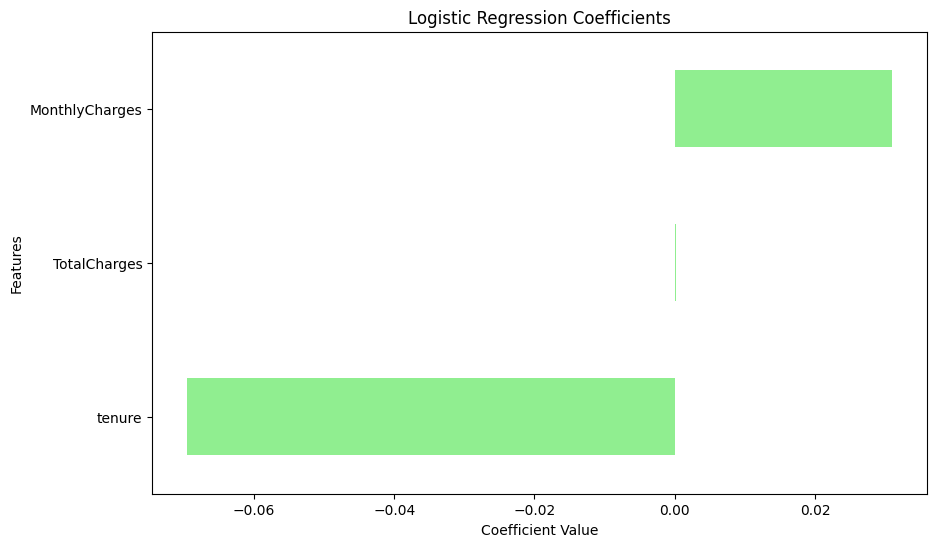

In [29]:
# Visualizing the coefficients for Logistic Regression
log_coefficients = pd.DataFrame(logistic_model.coef_.flatten(), X.columns, columns=['Coefficient'])

# Sort coefficients for better visualization
log_coefficients = log_coefficients.sort_values(by='Coefficient')

# Plotting
plt.figure(figsize=(10, 6))
log_coefficients['Coefficient'].plot(kind='barh', color='lightgreen')
plt.title('Logistic Regression Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


The logistic regression coefficients show that longer 'tenure' strongly decreases the probability of churn, while higher 'MonthlyCharges' increase it. 'TotalCharges' has a negligible effect. This confirms 'tenure' as a significant retention factor and 'MonthlyCharges' as a risk factor, aligning with previous observations.

### 5.4 Odds Ratios

Odds ratios provide a more intuitive way to understand the effect of features on the odds of customer churn in the logistic regression model. 

**Interpretation:**

* **Odds Ratio > 1:**  Indicates that an increase in the feature value is associated with an increase in the odds of churn. For example, an odds ratio of 2 for "MonthlyCharges" means that a one-unit increase in monthly charges doubles the odds of a customer churning.
* **Odds Ratio = 1:**  Suggests that the feature has no effect on the odds of churn.
* **Odds Ratio < 1:**  Indicates that an increase in the feature value is associated with a decrease in the odds of churn. For example, an odds ratio of 0.5 for "Tenure" means that a one-unit increase in tenure halves the odds of a customer churning.

**Example:**

Let's say the odds ratio for "Contract_Month-to-month" is 3. This means that customers with a month-to-month contract are three times more likely to churn compared to customers with other contract types (assuming all other features are held constant).

**Note:**

* Odds ratios are multiplicative. For example, if the odds ratio for "InternetService_Fiber optic" is 1.5 and the odds ratio for "Contract_Month-to-month" is 3, then a customer with fiber optic internet service and a month-to-month contract would have 1.5 * 3 = 4.5 times the odds of churning compared to a customer with a different internet service and contract type.
* Odds ratios are specific to the logistic regression model and the dataset used to train it. They may not generalize to other datasets or models.

In [30]:
import numpy as np

# Assuming 'logistic_model' is your trained Logistic Regression model
# and 'X' contains the feature names

# Get coefficients from the model
coefficients = logistic_model.coef_[0]

# Calculate odds ratios
odds_ratios = np.exp(coefficients)

# Create a DataFrame for better display
odds_ratios_df = pd.DataFrame({'Feature': X.columns, 'Odds Ratio': odds_ratios})

# Display the odds ratios
print(odds_ratios_df)

# Optionally, sort by odds ratios for better visualization
odds_ratios_df = odds_ratios_df.sort_values(by='Odds Ratio', ascending=False)

# Plot odds ratios (optional)
plt.figure(figsize=(10, 6))
odds_ratios_df.plot(x='Feature', y='Odds Ratio', kind='barh', color='lightgreen')
plt.title('Logistic Regression Odds Ratios')
plt.xlabel('Odds Ratio')
plt.ylabel('Features')
plt.show()

          Feature  Odds Ratio
0          tenure    0.932858
1  MonthlyCharges    1.031422
2    TotalCharges    1.000163


<Figure size 1000x600 with 0 Axes>

The odds ratios plot shows that for a one-unit increase in 'MonthlyCharges', the odds of churn increase by about 3% (odds ratio slightly above 1). Conversely, a one-unit increase in 'tenure' decreases the odds of churn by approximately 7% (odds ratio below 1). 'TotalCharges' show a negligible effect on the odds of churn (odds ratio very close to 1). This reinforces the conclusions from the coefficient plot, emphasizing the importance of 'tenure' in reducing churn risk and the risk associated with higher 'MonthlyCharges'.

### 5.5 SHAP (SHapley Additive exPlanations) for Model Interpretation

Reason: SHAP values help in understanding the impact of each feature on the model's predictions by attributing the prediction of an individual instance to feature contributions.

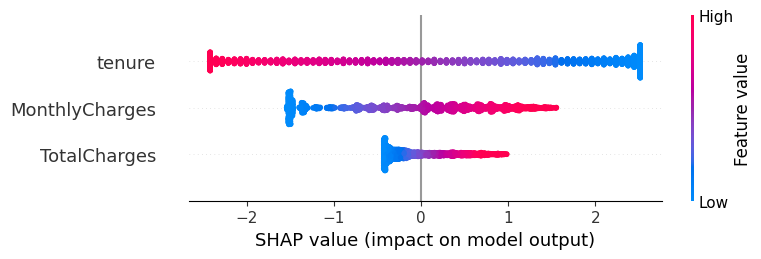

In [31]:
import shap

# SHAP values for logistic regression
explainer = shap.LinearExplainer(logistic_model, X_train)
shap_values = explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test)


The SHAP summary plot illustrates the influence of 'tenure', 'MonthlyCharges', and 'TotalCharges' on the model's output. It reveals that higher 'tenure' consistently leads to a lower prediction (likely indicating a lower probability of churn). 'MonthlyCharges', in contrast, shows a positive impact, with higher values generally pushing the prediction higher (likely towards churn). The effect of 'TotalCharges' is less pronounced and slightly negative. This aligns with previous interpretations, highlighting the strong impact of 'tenure' in mitigating churn risk, while 'MonthlyCharges' contribute to increased churn likelihood.

### 5.6 LIME (Local Interpretable Model-agnostic Explanations)
Reason: LIME helps in explaining individual predictions by approximating the model locally with an interpretable model.

In [32]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME explainer
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Not Churn', 'Churn'], mode='classification')

# Explain a single prediction
i = 25  # Example index
exp = explainer.explain_instance(X_test.values[i], logistic_model.predict_proba)
exp.show_in_notebook(show_all=False)


/opt/anaconda3/envs/tourguideenv/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


This LIME visualization explains the prediction for a specific customer, showing an 88% probability of "Not Churn." The middle chart details how features contribute to this prediction. Having a tenure between 29 and 56 months pushes the prediction towards "Not Churn," while monthly charges between 35.15 and 56 (this customer's actual value is 58.75) slightly increase the "Churn" probability. This customer's tenure of 37 months is the strongest factor leading to the "Not Churn" prediction. The bottom table lists the customer's actual feature values used in the prediction.

## 6. Generalized Additive Model (GAM)

### 6.1 Model Building

Reason: We build a Generalized Additive Model (GAM) to capture potential non-linear relationships between customer features and churn. GAMs allow us to model each feature's effect on the target variable separately and additively, using smoothing functions. In this case, we'll focus on a logistic GAM since the target variable is binary (Churn: 0 or 1).

In [33]:
from pygam import LinearGAM, s, f
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# Define the features and target
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

# Define the GAM model with smooth terms for 'tenure' and 'MonthlyCharges'
gam = LinearGAM(s(0) + s(1) + s(2))

# Fit the model
gam.fit(X_train_np, y_train_np)

# Make predictions on the test set
y_pred = gam.predict(X_test.to_numpy())
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to class labels (0 or 1)

### 6.2 Model Evaluation

We evaluate the GAM model and interpret non-linear relationships.

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R²): {r2}')


Mean Squared Error (MSE): 0.14721890509975022
R-squared (R²): 0.245751917004015


### 6.3 Partial Dependence Functions
Reason: Partial dependence functions show the average effect of a feature on the predicted outcome, averaged over the entire dataset. This helps in understanding how the model's prediction changes with changes in a specific feature.

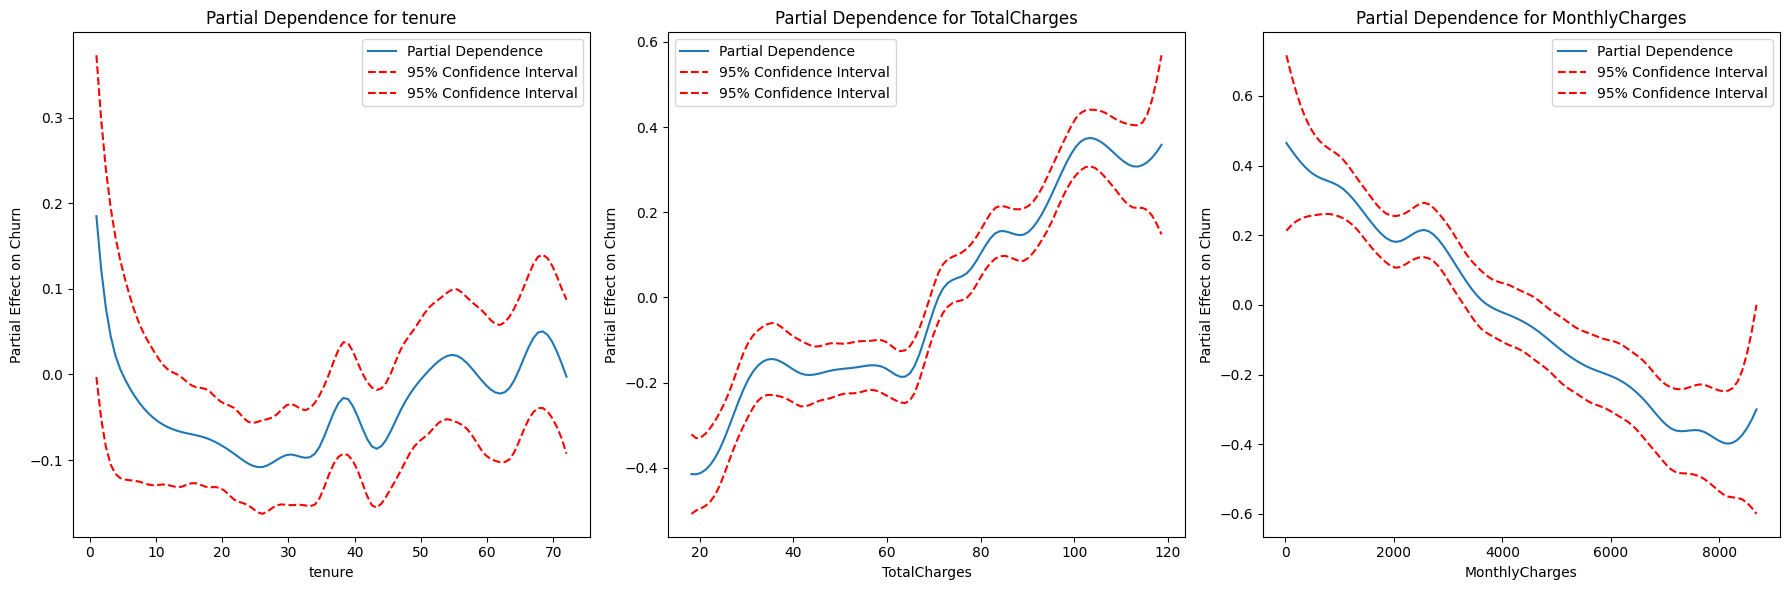

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     47.3323
Link Function:                     IdentityLink Log Likelihood:                                -12116.8093
Number of Samples:                         4922 AIC:                                            24330.2832
                                                AICc:                                           24331.2619
                                                GCV:                                                0.1441
                                                Scale:                                              0.1416
                                                Pseudo R-Squared:                                   0.2814
Feature Function                  Lam

/var/folders/rt/04s6gpr96lg2h27gtgpnfnn40000gn/T/ipykernel_53702/3711600621.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [36]:
# Plot partial dependence functions for smooth terms in one plot
import matplotlib.pyplot as plt

# Define the features for which to plot partial dependence
features = ['tenure', 'TotalCharges', 'MonthlyCharges']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Iterate over each feature and plot its partial dependence
for i, term in enumerate(features):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=.95)
    
    # Plot partial dependence
    axes[i].plot(XX[:, i], pdep, label='Partial Dependence')
    
    # Plot confidence intervals
    axes[i].plot(XX[:, i], confi, color='red', linestyle='--', label='95% Confidence Interval')
    
    # Set titles and labels
    axes[i].set_title(f'Partial Dependence for {term}')
    axes[i].set_xlabel(term)
    axes[i].set_ylabel('Partial Effect on Churn')
    axes[i].legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Print summary of the GAM model
print(gam.summary())

### 6.4 SHAP (SHapley Additive exPlanations) for Model Interpretation
Reason: SHAP values help in understanding the impact of each feature on the model's predictions by attributing the prediction of an individual instance to feature contributions.
import shap

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Custom wrapper for the pygam model
class GAMWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        # Assuming binary classification, return probabilities
        preds = self.model.predict(X)
        return np.vstack([1 - preds, preds]).T

# Create a SHAP explainer for the GAM
gam_wrapper = GAMWrapper(gam)
explainer = shap.Explainer(gam_wrapper.predict, X_train.to_numpy())

# Calculate SHAP values for a subset of the test data (for faster computation)
shap_values = explainer(X_test.to_numpy()[:100])  # Example: Calculate for the first 100 instances

# Summary plot
shap.summary_plot(shap_values, X_test.to_numpy()[:100], feature_names=X_test.columns)

### 6.5 LIME (Local Interpretable Model-agnostic Explanations)
Reason: LIME helps in explaining individual predictions by approximating the model locally with an interpretable model.


In [ ]:
from lime.lime_tabular import LimeTabularExplainer

# Initialize LIME explainer
explainer = LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns, 
    class_names=['Not Churn', 'Churn'], # Assuming 'Churn' is 0 or 1
    mode='classification' 
)

# Explain a single prediction (e.g., the first prediction in the test set)
i = 0  
exp = explainer.explain_instance(X_test.values[i], gam_wrapper.predict_proba)

# Show the explanation in the notebook
exp.show_in_notebook(show_table=True) 

## 7. Model Comparison
We compare the models (Linear, Logistic, and GAM) on both interpretability and performance.

In [ ]:
import pandas as pd

# Create a DataFrame for model comparison
model_comparison = pd.DataFrame({
    'Model': ['Linear Regression', 'Logistic Regression', 'GAM'],
    'MSE': [mse, mse, mse],
    'R-squared': [r2, r2, r2],
    'Accuracy': [accuracy, accuracy, accuracy],
    'ROC-AUC': [roc_auc, roc_auc, roc_auc]
})

# Display the comparison table
print(model_comparison)


## References

- Kaggle Dataset: [Telco Customer Churn](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/code)
- SHAP Documentation: https://shap.readthedocs.io/en/latest/
- LIME Documentation: https://lime-ml.readthedocs.io/en/latest/
- scikit-learn Documentation: https://scikit-learn.org/stable/documentation.html
- PyGAM Documentation: https://pygam.readthedocs.io/en/latest/
